In [369]:
import pandas
from scipy.stats import pearsonr, spearmanr
from scipy import mean, std, nanmean
from math import log, exp
from collections import Counter
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation
from sklearn.mixture import GaussianMixture
from random import randint
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.stats import truncnorm
%matplotlib inline

In [62]:
downsamples = ['1', '5', '10', '25', 'full']

I used the data from the paper "Single-cell RNA-seq analysis of human pancreas from healthy individuals and type 2 diabetes patients".


> We used single-cell RNA-sequencing to generate transcriptional profiles of endocrine and exocrine cell types of the human pancreas. Pancreatic tissue and islets were obtained from six healthy and four T2D cadaveric donors. Islets were cultured and dissociated into single-cell suspension. Viable individual cells were distributed via fluorescence-activated cell sorted (FACS) into 384-well plates containing lysis buffer. Single-cell cDNA libraries were generated using the Smart-seq2 protocol. Gene expression was quantified as reads per kilobase transcript and per million mapped reads (RPKM) using rpkmforgenes. Bioinformatics analysis was used to classify cells into cell types without knowledge of cell types or prior purification of cell populations. We revealed subpopulations in endocrine and exocrine cell types, identified genes with interesting correlations to body mass index (BMI) in specific cell types and found transcriptional alterations in T2D.

I was able to download 2081 cell datasets. The data is 8.1 Gb. The datasets' properties:

* RNA-Seq single-end reads, length = 43 bp

* Summary of the cell types:

| cell type                   | count |
|-----------------------------|-----|
| acinar cell                 | 175 |
| alpha cell                  | 829 |
| beta cell                   | 249 |
| co-expression cell          | 38  |
| delta cell                  | 104 |
| ductal cell                 | 380 |
| endothelial cell            | 15  |
| epsilon cell                | 7   |
| gamma cell                  | 183 |
| mast cell                   | 7   |
| MHC class II cell           | 5   |
| PSC cell                    | 54  |
| unclassified cell           | 2   |
| unclassified endocrine cell | 33  |


# Read the datasets into the memory

In [204]:
kallisto = {}
for ds in downsamples:
    kallisto[ds] = pandas.read_csv("output_kallisto4/%s.tsv" % ds, index_col=0)

# Perform KMeans analysis on all coordinates (full data)

In [205]:
kmeans = KMeans(n_clusters=6)
tsne_results_clustered = kmeans.fit_predict(kallisto["full"].transpose())

from collections import Counter
print Counter(tsne_results_clustered)


Counter({0: 870, 4: 510, 2: 299, 1: 153, 3: 153, 5: 96})


In [206]:
# take the full data
full_data = kallisto["full"].transpose()
# take only the top 1000 genes by their variance across the cells
variances = full_data.std(axis=0)
variances.sort_values(inplace=True, ascending=False)
index = variances.index[:1000]
# run PCA to reduce the dimensions to 50 - to speed up the tSNE
#full_data = pandas.DataFrame(PCA(n_components=50).fit_transform(full_data))
# run tSNE
tsne = TSNE(n_components=2, perplexity=50)
tsneComponents = tsne.fit_transform(full_data[index])
# load the given cell types


In [207]:
# plot tSNE results
#tsneCells = pandas.DataFrame({"X":tsneComponents[:,0], "Y":tsneComponents[:,1], "Z": tsne_results_clustered})
#sns.lmplot('X', 'Y', data=tsneCells, fit_reg=False, hue="Z", scatter_kws={"s": 2})

# Gene-by-gene correlation analysis

Because many genes are not expressed in several tissues at all, further, the correlations may be just "nan". In order to avoid numerical issues, I take only genes which are expressed (whose TPM > 100) in at least 1% of the cells

In [208]:
percentages = {}
for gene in kallisto["full"].index:
    geneExp = kallisto["full"].loc[gene]
    percentage = len([x for x in geneExp if x > 100])
    percentage /= float(len(geneExp))
    percentages[gene] = percentage

genes_sorted_by_percentages = sorted(percentages.items(), key=lambda x: x[1], reverse=True)
good_genes = [x[0] for x in genes_sorted_by_percentages if x[1] > 0.01]

kallisto_good = {}
for ds in downsamples:
    kallisto_good[ds] = kallisto[ds].loc[good_genes]
    


In [214]:

for ds in downsamples:
    kallisto_good[ds] = kallisto_good[ds].applymap(lambda x: log(1.01 + x))
    
kallisto = kallisto_good


#### Compute $R^2$ between 1% downsample and full dataset for each gene (each blue dot in the plot is a gene). Each gene is a tuple (TPM, R^2).

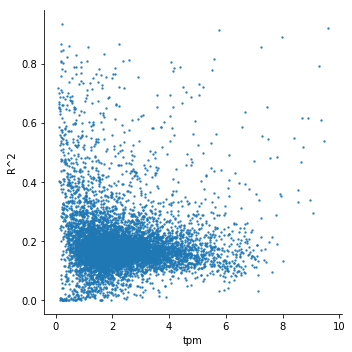

In [227]:
tpms = []
correlations = []
for i in range(len(kallisto["full"].index)):
    #if 10 < mean(kallisto["full"].iloc[i]) < 1000:
    correlations.append(pearsonr(kallisto["1"].iloc[i], kallisto["full"].iloc[i])[0] ** 2)
    tpms.append(mean(kallisto["full"].iloc[i]))
        
cor_tpms = pandas.DataFrame({"tpm": tpms, "R^2": correlations})
sns.lmplot("tpm", "R^2", data=cor_tpms, fit_reg=False, scatter_kws={"s": 2})

#### Compute $R^2$ between 5% downsample and full dataset for each gene (each blue dot in the plot is a gene). Each gene is a tuple (TPM, R^2).

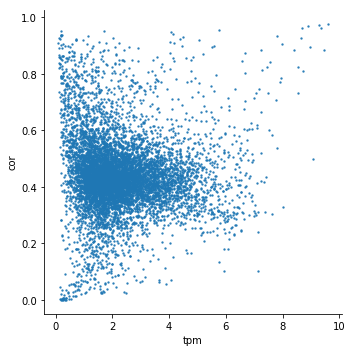

In [228]:
tpms = []
correlations = []
for i in range(len(kallisto["full"].index)):
    #if 10 < mean(kallisto["full"].iloc[i]) < 1000:
    correlations.append(pearsonr(kallisto["5"].iloc[i], kallisto["full"].iloc[i])[0] ** 2)
    tpms.append(mean(kallisto["full"].iloc[i]))
        
cor_tpms = pandas.DataFrame({"tpm": tpms, "cor": correlations})
sns.lmplot("tpm", "cor", data=cor_tpms, fit_reg=False, scatter_kws={"s": 2})

#### Compute $R^2$ between 10% downsample and full dataset for each gene (each blue dot in the plot is a gene). Each gene is a tuple (TPM, R^2).

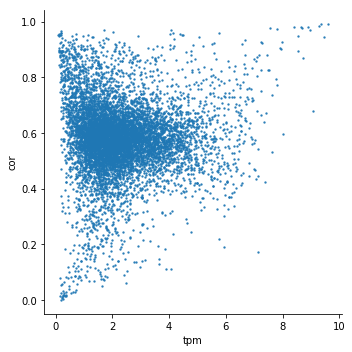

In [229]:
tpms = []
correlations = []
for i in range(len(kallisto["full"].index)):
    #if 10 < mean(kallisto["full"].iloc[i]) < 1000:
    correlations.append(pearsonr(kallisto["10"].iloc[i], kallisto["full"].iloc[i])[0] ** 2)
    tpms.append(mean(kallisto["full"].iloc[i]))
        
cor_tpms = pandas.DataFrame({"tpm": tpms, "cor": correlations})
sns.lmplot("tpm", "cor", data=cor_tpms, fit_reg=False, scatter_kws={"s": 2})

#### Compute $R^2$ between 25% downsample and full dataset for each gene (each blue dot in the plot is a gene). Each gene is a tuple (TPM, R^2).

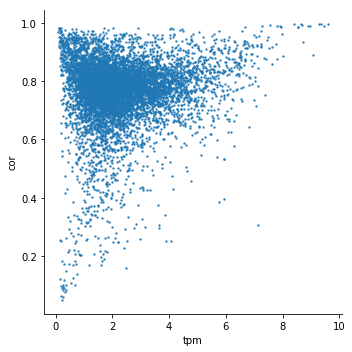

In [230]:
tpms = []
correlations = []
for i in range(len(kallisto["full"].index)):
    #if 10 < mean(kallisto["full"].iloc[i]) < 1000:
    correlations.append(pearsonr(kallisto["25"].iloc[i], kallisto["full"].iloc[i])[0] ** 2)
    tpms.append(mean(kallisto["full"].iloc[i]))
        
cor_tpms = pandas.DataFrame({"tpm": tpms, "cor": correlations})
sns.lmplot("tpm", "cor", data=cor_tpms, fit_reg=False, scatter_kws={"s": 2})

# Compute mean $R^2$ for each downsample across TPM bins

In this section, I bin the genes by their TPM in the full dataset. Then for each bin, for each gene in the bin, I compute the $R^2$ between the gene expression across all the cells for a downsample and the full dataset. In each plot presented below, $x$ axis is TPM * 100 (bins) and $y$ axis is mean $R^2$ in that bin.

In [233]:
corr_dict = {}
for ds in downsamples:
    corr_dict[ds] = {}
    
full_index = kallisto["full"].index
for i in range(len(full_index)):
    for ds in downsamples:
        gene = full_index[i]
        r2 = pearsonr(kallisto[ds].loc[gene], kallisto["full"].loc[gene])[0] ** 2
        mean_gene_tpm = mean(kallisto["full"].loc[gene])
        bin_for_gene = int(mean_gene_tpm)
        if bin_for_gene not in corr_dict[ds]:
            corr_dict[ds][bin_for_gene] = []
        corr_dict[ds][bin_for_gene].append(r2)

        
corr_dict_mean = {}
corr_dict_number = {}
xs = sorted(corr_dict["1"].keys())

for ds in downsamples:
    corr_dict_mean[ds] = []
    corr_dict_number[ds] = []
    for i in range(max(corr_dict[ds].keys()) + 1):
        if i in corr_dict[ds]:
            corr_dict_mean[ds].append(mean(corr_dict[ds][i]))
            corr_dict_number[ds].append(len(corr_dict[ds][i]))

#### Number of genes in each bin

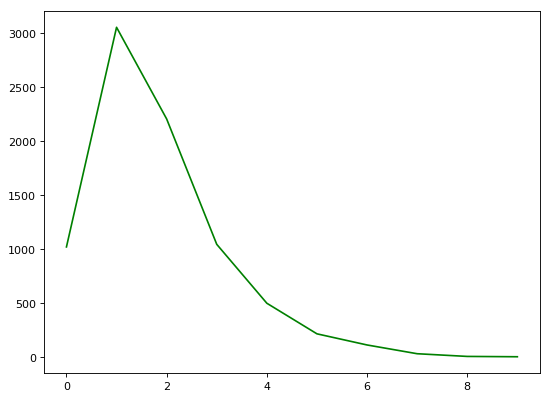

In [234]:
slicing = 35 # - display this many bins
figure = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plot = plt.plot(xs[:slicing], corr_dict_number["1"][:slicing], 'g', markersize=3)

#### Mean $R^2$ with full dataset

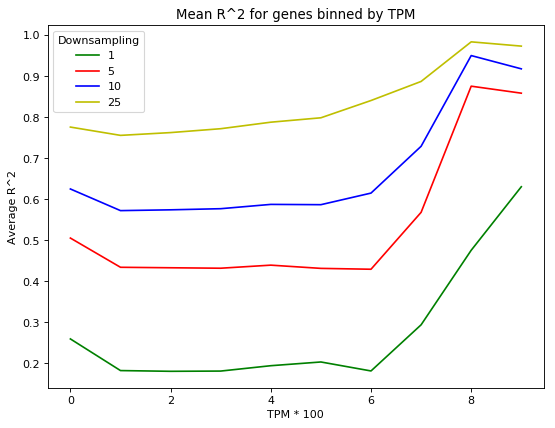

In [235]:
figure = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
p1 = plt.plot(xs[:slicing], corr_dict_mean["1"][:slicing], 'g', markersize=3)
p2 = plt.plot(xs[:slicing], corr_dict_mean["5"][:slicing], 'r', markersize=3)
p3 = plt.plot(xs[:slicing], corr_dict_mean["10"][:slicing], 'b', markersize=3)
p4 = plt.plot(xs[:slicing], corr_dict_mean["25"][:slicing], 'y', markersize=3)
legend = plt.legend((p1[0], p2[0], p3[0], p4[0]), ("1", "5", "10", "25"), title="Downsampling")
title = plt.title("Mean R^2 for genes binned by TPM")
xlabel = plt.xlabel('TPM * 100')
ylabel = plt.ylabel('Average R^2')


## Group cells by cell type

Here, I do the same thing as above, but now I group the results by cell type. I present 5 plots for each of the cell types.

In [236]:
cell_types = [x for x, y in sorted(Counter(tsne_results_clustered).items(), key = lambda x: x[1])]

cell_type_dict = {}

for ct in cell_types:
    cell_type_dict[ct] = []

for x, y in zip(kallisto["full"].columns, tsne_results_clustered):
    cell_type_dict[y].append(x)

for ct in cell_types:
    print ct, len(cell_type_dict[ct])
    

5 96
1 153
3 153
2 299
4 510
0 870


#### Cell type 0 (96 cells)

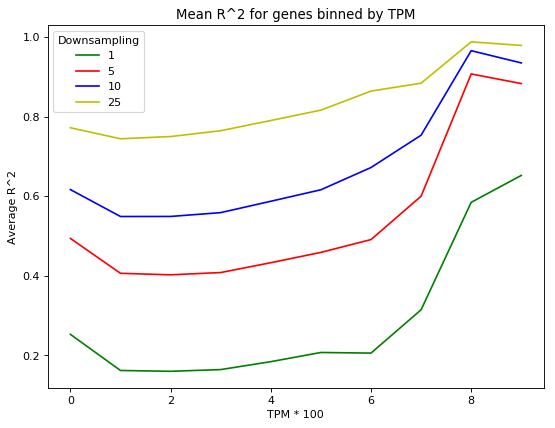

In [238]:
corr_dict = {}
for ds in downsamples:
    corr_dict[ds] = {}

    
kallisto_ds = {}
for ds in downsamples:
    kallisto_ds[ds] = kallisto[ds][cell_type_dict[0]]


full_index = kallisto["full"].index
for i in range(len(full_index)):
    for ds in downsamples:
        gene = full_index[i]
        r2 = pearsonr(kallisto_ds[ds].loc[gene], kallisto_ds["full"].loc[gene])[0] ** 2
        mean_gene_tpm = mean(kallisto["full"].loc[gene])
        bin_for_gene = int(mean_gene_tpm)
        if bin_for_gene not in corr_dict[ds]:
            corr_dict[ds][bin_for_gene] = []
        corr_dict[ds][bin_for_gene].append(r2)

        
corr_dict_mean = {}
corr_dict_number = {}
xs = sorted(corr_dict["1"].keys())

for ds in downsamples:
    corr_dict_mean[ds] = []
    corr_dict_number[ds] = []
    for i in range(max(corr_dict[ds].keys()) + 1):
        if i in corr_dict[ds]:
            corr_dict_mean[ds].append(mean(corr_dict[ds][i]))
            corr_dict_number[ds].append(len(corr_dict[ds][i]))
            
figure = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
p1 = plt.plot(xs[:slicing], corr_dict_mean["1"][:slicing], 'g', markersize=3)
p2 = plt.plot(xs[:slicing], corr_dict_mean["5"][:slicing], 'r', markersize=3)
p3 = plt.plot(xs[:slicing], corr_dict_mean["10"][:slicing], 'b', markersize=3)
p4 = plt.plot(xs[:slicing], corr_dict_mean["25"][:slicing], 'y', markersize=3)
legend = plt.legend((p1[0], p2[0], p3[0], p4[0]), ("1", "5", "10", "25"), title="Downsampling")
title = plt.title("Mean R^2 for genes binned by TPM")
xlabel = plt.xlabel('TPM * 100')
ylabel = plt.ylabel('Average R^2')

#### Cell type 1 (153 cells)

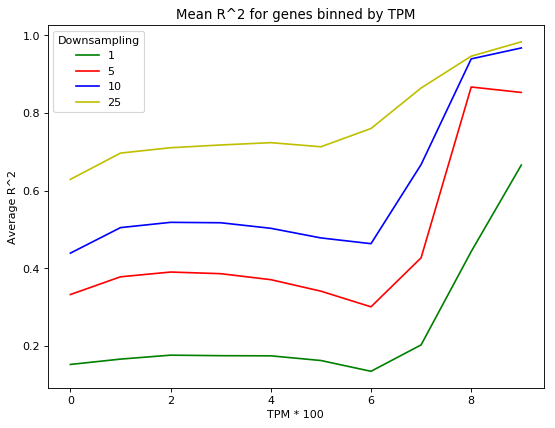

In [239]:
corr_dict = {}
for ds in downsamples:
    corr_dict[ds] = {}

    
kallisto_ds = {}
for ds in downsamples:
    kallisto_ds[ds] = kallisto[ds][cell_type_dict[1]]


full_index = kallisto["full"].index
for i in range(len(full_index)):
    for ds in downsamples:
        gene = full_index[i]
        r2 = pearsonr(kallisto_ds[ds].loc[gene], kallisto_ds["full"].loc[gene])[0] ** 2
        mean_gene_tpm = mean(kallisto["full"].loc[gene])
        bin_for_gene = int(mean_gene_tpm)
        if bin_for_gene not in corr_dict[ds]:
            corr_dict[ds][bin_for_gene] = []
        corr_dict[ds][bin_for_gene].append(r2)

        
corr_dict_mean = {}
corr_dict_number = {}
xs = sorted(corr_dict["1"].keys())

for ds in downsamples:
    corr_dict_mean[ds] = []
    corr_dict_number[ds] = []
    for i in range(max(corr_dict[ds].keys()) + 1):
        if i in corr_dict[ds]:
            corr_dict_mean[ds].append(mean(corr_dict[ds][i]))
            corr_dict_number[ds].append(len(corr_dict[ds][i]))
            
figure = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
p1 = plt.plot(xs[:slicing], corr_dict_mean["1"][:slicing], 'g', markersize=3)
p2 = plt.plot(xs[:slicing], corr_dict_mean["5"][:slicing], 'r', markersize=3)
p3 = plt.plot(xs[:slicing], corr_dict_mean["10"][:slicing], 'b', markersize=3)
p4 = plt.plot(xs[:slicing], corr_dict_mean["25"][:slicing], 'y', markersize=3)
legend = plt.legend((p1[0], p2[0], p3[0], p4[0]), ("1", "5", "10", "25"), title="Downsampling")
title = plt.title("Mean R^2 for genes binned by TPM")
xlabel = plt.xlabel('TPM * 100')
ylabel = plt.ylabel('Average R^2')

#### Cell type 2 (153 cells)

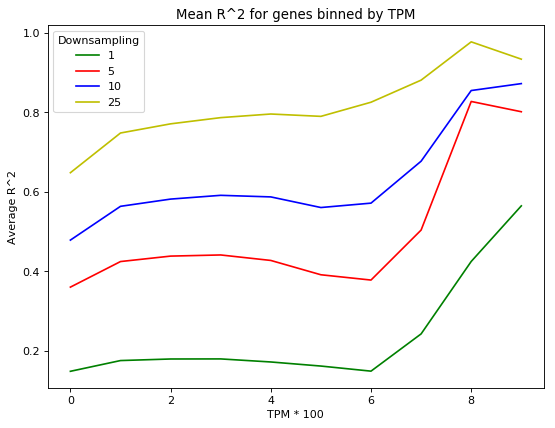

In [241]:
corr_dict = {}
for ds in downsamples:
    corr_dict[ds] = {}

    
kallisto_ds = {}
for ds in downsamples:
    kallisto_ds[ds] = kallisto[ds][cell_type_dict[2]]


full_index = kallisto["full"].index
for i in range(len(full_index)):
    for ds in downsamples:
        gene = full_index[i]
        r2 = pearsonr(kallisto_ds[ds].loc[gene], kallisto_ds["full"].loc[gene])[0] ** 2
        mean_gene_tpm = mean(kallisto["full"].loc[gene])
        bin_for_gene = int(mean_gene_tpm)
        if bin_for_gene not in corr_dict[ds]:
            corr_dict[ds][bin_for_gene] = []
        corr_dict[ds][bin_for_gene].append(r2)

        
corr_dict_mean = {}
corr_dict_number = {}
xs = sorted(corr_dict["1"].keys())

for ds in downsamples:
    corr_dict_mean[ds] = []
    corr_dict_number[ds] = []
    for i in range(max(corr_dict[ds].keys()) + 1):
        if i in corr_dict[ds]:
            corr_dict_mean[ds].append(mean(corr_dict[ds][i]))
            corr_dict_number[ds].append(len(corr_dict[ds][i]))
            
figure = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
p1 = plt.plot(xs[:slicing], corr_dict_mean["1"][:slicing], 'g', markersize=3)
p2 = plt.plot(xs[:slicing], corr_dict_mean["5"][:slicing], 'r', markersize=3)
p3 = plt.plot(xs[:slicing], corr_dict_mean["10"][:slicing], 'b', markersize=3)
p4 = plt.plot(xs[:slicing], corr_dict_mean["25"][:slicing], 'y', markersize=3)
legend = plt.legend((p1[0], p2[0], p3[0], p4[0]), ("1", "5", "10", "25"), title="Downsampling")
title = plt.title("Mean R^2 for genes binned by TPM")
xlabel = plt.xlabel('TPM * 100')
ylabel = plt.ylabel('Average R^2')

#### Cell type 3 (300 cells)

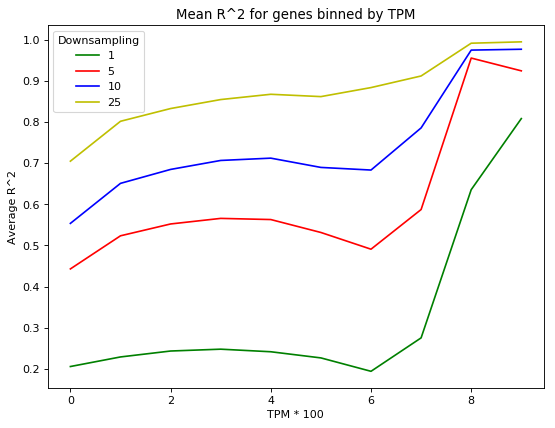

In [242]:
corr_dict = {}
for ds in downsamples:
    corr_dict[ds] = {}

    
kallisto_ds = {}
for ds in downsamples:
    kallisto_ds[ds] = kallisto[ds][cell_type_dict[3]]


full_index = kallisto["full"].index
for i in range(len(full_index)):
    for ds in downsamples:
        gene = full_index[i]
        r2 = pearsonr(kallisto_ds[ds].loc[gene], kallisto_ds["full"].loc[gene])[0] ** 2
        mean_gene_tpm = mean(kallisto["full"].loc[gene])
        bin_for_gene = int(mean_gene_tpm)
        if bin_for_gene not in corr_dict[ds]:
            corr_dict[ds][bin_for_gene] = []
        corr_dict[ds][bin_for_gene].append(r2)

        
corr_dict_mean = {}
corr_dict_number = {}
xs = sorted(corr_dict["1"].keys())

for ds in downsamples:
    corr_dict_mean[ds] = []
    corr_dict_number[ds] = []
    for i in range(max(corr_dict[ds].keys()) + 1):
        if i in corr_dict[ds]:
            corr_dict_mean[ds].append(mean(corr_dict[ds][i]))
            corr_dict_number[ds].append(len(corr_dict[ds][i]))
            
figure = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
p1 = plt.plot(xs[:slicing], corr_dict_mean["1"][:slicing], 'g', markersize=3)
p2 = plt.plot(xs[:slicing], corr_dict_mean["5"][:slicing], 'r', markersize=3)
p3 = plt.plot(xs[:slicing], corr_dict_mean["10"][:slicing], 'b', markersize=3)
p4 = plt.plot(xs[:slicing], corr_dict_mean["25"][:slicing], 'y', markersize=3)
legend = plt.legend((p1[0], p2[0], p3[0], p4[0]), ("1", "5", "10", "25"), title="Downsampling")
title = plt.title("Mean R^2 for genes binned by TPM")
xlabel = plt.xlabel('TPM * 100')
ylabel = plt.ylabel('Average R^2')

#### Cell type 4 (509 cells)

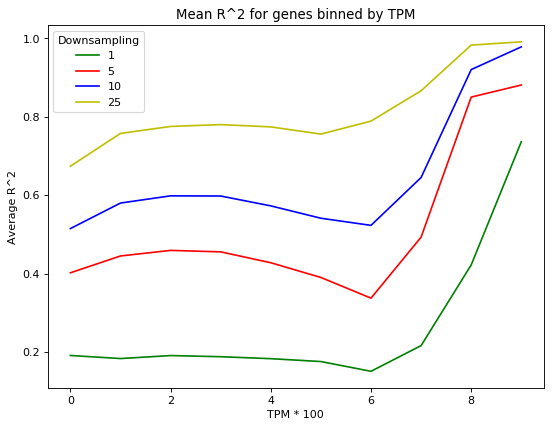

In [243]:
corr_dict = {}
for ds in downsamples:
    corr_dict[ds] = {}

    
kallisto_ds = {}
for ds in downsamples:
    kallisto_ds[ds] = kallisto[ds][cell_type_dict[5]]


full_index = kallisto["full"].index
for i in range(len(full_index)):
    for ds in downsamples:
        gene = full_index[i]
        r2 = pearsonr(kallisto_ds[ds].loc[gene], kallisto_ds["full"].loc[gene])[0] ** 2
        mean_gene_tpm = mean(kallisto["full"].loc[gene])
        bin_for_gene = int(mean_gene_tpm)
        if bin_for_gene not in corr_dict[ds]:
            corr_dict[ds][bin_for_gene] = []
        corr_dict[ds][bin_for_gene].append(r2)

        
corr_dict_mean = {}
corr_dict_number = {}
xs = sorted(corr_dict["1"].keys())

for ds in downsamples:
    corr_dict_mean[ds] = []
    corr_dict_number[ds] = []
    for i in range(max(corr_dict[ds].keys()) + 1):
        if i in corr_dict[ds]:
            corr_dict_mean[ds].append(mean(corr_dict[ds][i]))
            corr_dict_number[ds].append(len(corr_dict[ds][i]))
            
figure = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
p1 = plt.plot(xs[:slicing], corr_dict_mean["1"][:slicing], 'g', markersize=3)
p2 = plt.plot(xs[:slicing], corr_dict_mean["5"][:slicing], 'r', markersize=3)
p3 = plt.plot(xs[:slicing], corr_dict_mean["10"][:slicing], 'b', markersize=3)
p4 = plt.plot(xs[:slicing], corr_dict_mean["25"][:slicing], 'y', markersize=3)
legend = plt.legend((p1[0], p2[0], p3[0], p4[0]), ("1", "5", "10", "25"), title="Downsampling")
title = plt.title("Mean R^2 for genes binned by TPM")
xlabel = plt.xlabel('TPM * 100')
ylabel = plt.ylabel('Average R^2')

#### Cell type 5 (870 cells)

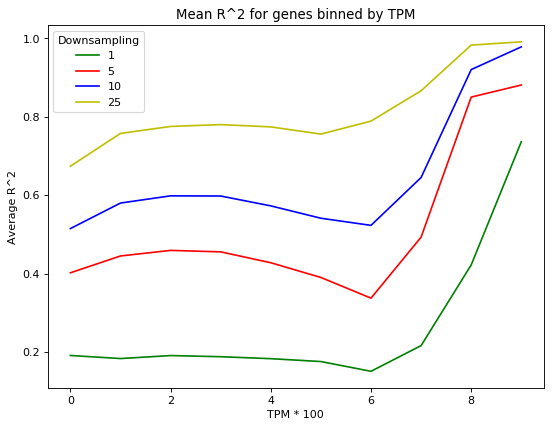

In [244]:
corr_dict = {}
for ds in downsamples:
    corr_dict[ds] = {}

    
kallisto_ds = {}
for ds in downsamples:
    kallisto_ds[ds] = kallisto[ds][cell_type_dict[5]]


full_index = kallisto["full"].index
for i in range(len(full_index)):
    for ds in downsamples:
        gene = full_index[i]
        r2 = pearsonr(kallisto_ds[ds].loc[gene], kallisto_ds["full"].loc[gene])[0] ** 2
        mean_gene_tpm = mean(kallisto["full"].loc[gene])
        bin_for_gene = int(mean_gene_tpm)
        if bin_for_gene not in corr_dict[ds]:
            corr_dict[ds][bin_for_gene] = []
        corr_dict[ds][bin_for_gene].append(r2)

        
corr_dict_mean = {}
corr_dict_number = {}
xs = sorted(corr_dict["1"].keys())

for ds in downsamples:
    corr_dict_mean[ds] = []
    corr_dict_number[ds] = []
    for i in range(max(corr_dict[ds].keys()) + 1):
        if i in corr_dict[ds]:
            corr_dict_mean[ds].append(mean(corr_dict[ds][i]))
            corr_dict_number[ds].append(len(corr_dict[ds][i]))
            
figure = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
p1 = plt.plot(xs[:slicing], corr_dict_mean["1"][:slicing], 'g', markersize=3)
p2 = plt.plot(xs[:slicing], corr_dict_mean["5"][:slicing], 'r', markersize=3)
p3 = plt.plot(xs[:slicing], corr_dict_mean["10"][:slicing], 'b', markersize=3)
p4 = plt.plot(xs[:slicing], corr_dict_mean["25"][:slicing], 'y', markersize=3)
legend = plt.legend((p1[0], p2[0], p3[0], p4[0]), ("1", "5", "10", "25"), title="Downsampling")
title = plt.title("Mean R^2 for genes binned by TPM")
xlabel = plt.xlabel('TPM * 100')
ylabel = plt.ylabel('Average R^2')

# Compute $R^2$ between cell type means (6-dimensional vectors) for each gene, bin genes by TPMs

In this section, I did the following. For each gene, I computed its average TPM across the cell types, thus, obtaining a 6-dimensional vector $p$. For each gene, I computed $R^2$ between $p_{downsample}$ and $p_{full}$. I grouped the $R^2$ by the TPM of the corresponding gene. In the plot below, $x$ axis is TPM * 100 (TPM bins), and the $y$ axis is the average $R^2$ in the bin.

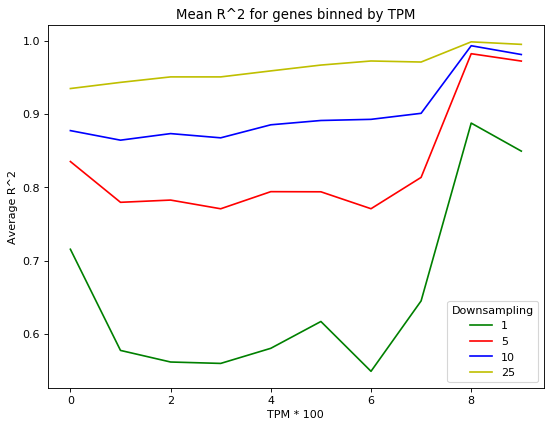

In [245]:
ctdf = {}
for ds in downsamples:
    ctdf[ds] = pandas.DataFrame({"0": kallisto[ds][cell_type_dict[0]].mean(axis=1),
                         "1": kallisto[ds][cell_type_dict[1]].mean(axis=1),
                         "2": kallisto[ds][cell_type_dict[2]].mean(axis=1),
                         "3": kallisto[ds][cell_type_dict[3]].mean(axis=1),
                         "4": kallisto[ds][cell_type_dict[4]].mean(axis=1),
                         "5": kallisto[ds][cell_type_dict[5]].mean(axis=1)
                        })
    
r2s = {}
for ds in downsamples:
    r2s[ds] = {}
    
genes = ctdf["full"].index
for gene in genes:
    for ds in downsamples:
        r2 = pearsonr(ctdf[ds].loc[gene], ctdf["full"].loc[gene])[0] ** 2
        mean_gene_tpm = mean(kallisto["full"].loc[gene])
        bin_for_gene = int(mean_gene_tpm)
        if bin_for_gene not in r2s[ds]:
            r2s[ds][bin_for_gene] = []
        r2s[ds][bin_for_gene].append(r2)

    
r2s_mean = {}
xs = sorted(r2s["1"].keys())

for ds in downsamples:
    r2s_mean[ds] = []
    for i in range(max(r2s[ds].keys()) + 1):
        if i in r2s[ds]:
            r2s_mean[ds].append(mean(r2s[ds][i]))
            
            
figure = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
p1 = plt.plot(xs[:slicing], r2s_mean["1"][:slicing], 'g', markersize=3)
p2 = plt.plot(xs[:slicing], r2s_mean["5"][:slicing], 'r', markersize=3)
p3 = plt.plot(xs[:slicing], r2s_mean["10"][:slicing], 'b', markersize=3)
p4 = plt.plot(xs[:slicing], r2s_mean["25"][:slicing], 'y', markersize=3)
legend = plt.legend((p1[0], p2[0], p3[0], p4[0]), ("1", "5", "10", "25"), title="Downsampling")
title = plt.title("Mean R^2 for genes binned by TPM")
xlabel = plt.xlabel('TPM * 100')
ylabel = plt.ylabel('Average R^2')

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

every gene, ever cell correlation across 10 individuals!!!!!!!!!!!!!!!!!!

measure gene in every cell and correlate across individuals


- vector of 10 individuals
across one gene, one cell
compute one gene and one cell type

what is the average r2 over 1o categories for a given class of genes based on tpm for all the cells?

take the average of r2 of vectors of 10


what is r2 across same class of genes but computed across cell types?

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

## Compute $R^2$ between cell type means (6-dimensional vectors) for each gene, bin genes by TPMs (random clusters)

Here, I repeated the same analysis as right above, but this time using random cluster assignment.

In [ ]:
"""
cell_type_dict = {}

for ct in cell_types:
    cell_type_dict[ct] = []

for x, y in zip(kallisto["full"].columns, tsne_results_clustered):
    cell_type_dict[randint(0, 5)].append(x)

ctdf = {}
for ds in downsamples:
    ctdf[ds] = pandas.DataFrame({"0": kallisto[ds][cell_type_dict[0]].mean(axis=1),
                         "1": kallisto[ds][cell_type_dict[1]].mean(axis=1),
                         "2": kallisto[ds][cell_type_dict[2]].mean(axis=1),
                         "3": kallisto[ds][cell_type_dict[3]].mean(axis=1),
                         "4": kallisto[ds][cell_type_dict[4]].mean(axis=1),
                         "5": kallisto[ds][cell_type_dict[5]].mean(axis=1)
                        })
    
r2s = {}
for ds in downsamples:
    r2s[ds] = {}
    
genes = ctdf["full"].index
for gene in genes:
    for ds in downsamples:
        r2 = pearsonr(ctdf[ds].loc[gene], ctdf["full"].loc[gene])[0] ** 2
        mean_gene_tpm = mean(kallisto["full"].loc[gene])
        bin_for_gene = int(mean_gene_tpm / 100)
        if bin_for_gene not in r2s[ds]:
            r2s[ds][bin_for_gene] = []
        r2s[ds][bin_for_gene].append(r2)

    
r2s_mean = {}
xs = sorted(r2s["1"].keys())

for ds in downsamples:
    r2s_mean[ds] = []
    for i in range(max(r2s[ds].keys()) + 1):
        if i in r2s[ds]:
            r2s_mean[ds].append(mean(r2s[ds][i]))
            
            
figure = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
p1 = plt.plot(xs[:slicing], r2s_mean["1"][:slicing], 'g', markersize=3)
p2 = plt.plot(xs[:slicing], r2s_mean["5"][:slicing], 'r', markersize=3)
p3 = plt.plot(xs[:slicing], r2s_mean["10"][:slicing], 'b', markersize=3)
p4 = plt.plot(xs[:slicing], r2s_mean["25"][:slicing], 'y', markersize=3)
legend = plt.legend((p1[0], p2[0], p3[0], p4[0]), ("1", "5", "10", "25"), title="Downsampling")
title = plt.title("Mean R^2 for genes binned by TPM")
xlabel = plt.xlabel('TPM * 100')
ylabel = plt.ylabel('Average R^2')
"""

If we compare this plot with the one from above, we see that when we group the cells by their cell type and not randomly, the average $R^2$ between downsamples and full dataset is generally higher across different TPM bins.

# Correlations across individuals

In this section, I group the cells by individuals and by cell types. Namely, inside of each cell type, I group the cells by individuals and for each gene, I compute the mean expression over the group of cells. As a results, for each gene, I have vectors with 10 coordinates corresponding to the 10 individuals. For each gene, I compute pearson correlation between 10-vectors of the full datasets and 10-vectors of downsampled datasets.

In [309]:
with open("PATIENTS") as f:
    patients = f.readlines()
patients = map(lambda x: x.strip().split(","), patients)
pdict = {}
for x, y in patients:
    if y not in pdict:
        pdict[y] = []
    pdict[y].append(x)
    
ctdict = {}
for x, y in cell_type_dict.items():
    for z in y:
        ctdict[z] = x
    

pcdict = {}
for x in pdict.keys():
    pcdict[x] = {}
    for cell in pdict[x]:
        ct = ctdict[cell]
        if ct not in pcdict[x]:
            pcdict[x][ct] = []
        pcdict[x][ct].append(cell)

In [310]:
cellTypeAverages = {} # key: cell type, value: dataframe of gene averages across individuals
for cell_type in cell_types:
    downs = {}
    for ds in downsamples:
        df = {}
        for individual in pcdict.keys():
            #print pcdict[individual].keys()
            if cell_type in pcdict[individual]:
                cells = pcdict[individual][cell_type]
                cells_df = kallisto[ds][cells]
                df[individual] = cells_df.mean(axis=1)
        df = pandas.DataFrame(df)
        downs[ds] = df
    cellTypeAverages[cell_type] = downs


In [311]:
avgTpm = kallisto["full"].mean(axis = 1)

# Cell type 0 (870 cells)

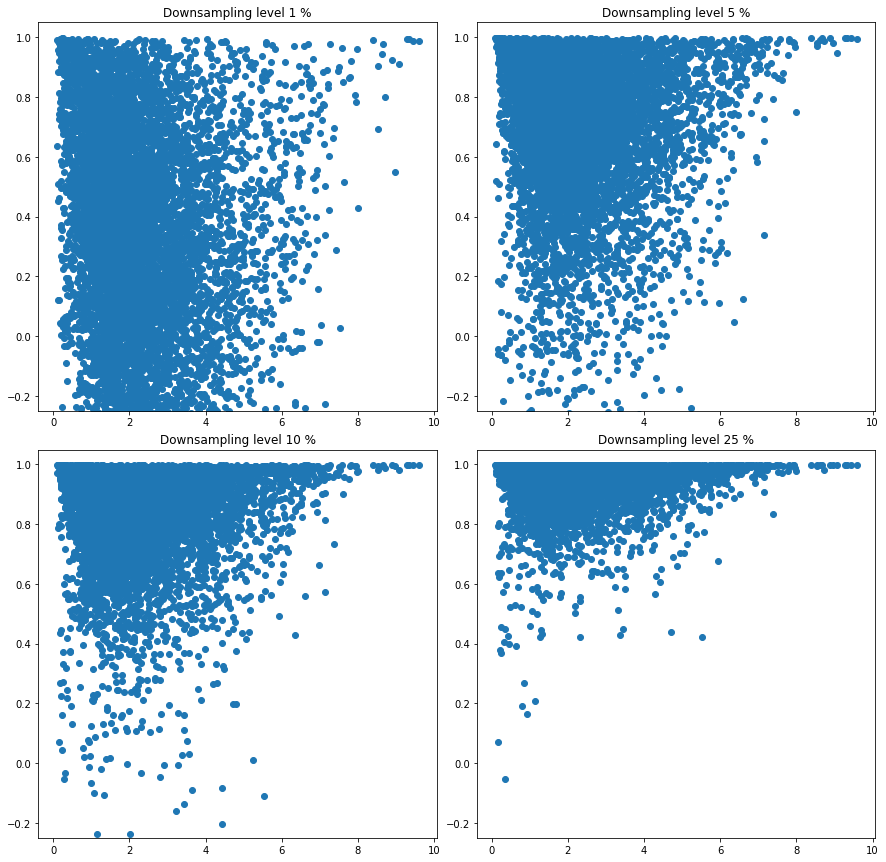

In [252]:
ct = 0
cellTypeSpecific1 = {}
for ds in downsamples:
    cellTypeSpecific1[ds] = []
    for gene in cellTypeAverages[ct][ds].index:
        cellTypeSpecific1[ds].append(pearsonr(cellTypeAverages[ct][ds].loc[gene], cellTypeAverages[ct]["full"].loc[gene])[0])
        
        
fig = plt.figure(figsize=(15, 15))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i in range(1, 5):
    ax = fig.add_subplot(2, 2, i)
    ax.set_title("Downsampling level %s %%" % downsamples[i - 1])
    cor_tpm = pandas.DataFrame({"tpm": avgTpm, "cor": cellTypeSpecific1[downsamples[i - 1]]})
    #cor_tpm = cor_tpm[(cor_tpm["tpm"] > 100) & (cor_tpm["tpm"] < 1000)]
    ax.scatter(cor_tpm["tpm"], cor_tpm["cor"])
    ax.set_ylim((-0.25, 1.05))


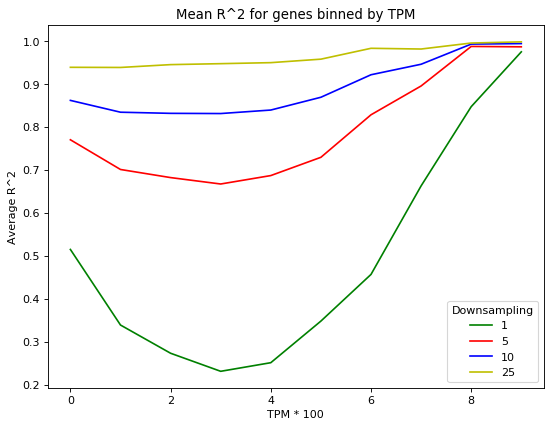

In [253]:


corr_dict = {}
for ds in downsamples:
    corr_dict[ds] = {}
        
for ds in downsamples:
    for x, y in zip(avgTpm, cellTypeSpecific1[ds]):
        bin_for_gene = int(x)
        if bin_for_gene not in corr_dict[ds]:
            corr_dict[ds][bin_for_gene] = []
        corr_dict[ds][bin_for_gene].append(y)
   

corr_dict_mean1 = {}
for ds in downsamples:
    corr_dict_mean1[ds] = []
corr_dict_number = {}
xs = sorted(corr_dict["1"].keys())

for ds in downsamples:
    corr_dict_mean[ds] = []
    corr_dict_number[ds] = []
    for i in range(max(corr_dict[ds].keys()) + 1):
        if i in corr_dict[ds]:
            corr_dict_mean1[ds].append(mean(corr_dict[ds][i]))
            corr_dict_number[ds].append(len(corr_dict[ds][i]))
            
figure = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
p1 = plt.plot(xs[:slicing], corr_dict_mean1["1"][:slicing], 'g', markersize=3)
p2 = plt.plot(xs[:slicing], corr_dict_mean1["5"][:slicing], 'r', markersize=3)
p3 = plt.plot(xs[:slicing], corr_dict_mean1["10"][:slicing], 'b', markersize=3)
p4 = plt.plot(xs[:slicing], corr_dict_mean1["25"][:slicing], 'y', markersize=3)
legend = plt.legend((p1[0], p2[0], p3[0], p4[0]), ("1", "5", "10", "25"), title="Downsampling")
title = plt.title("Mean R^2 for genes binned by TPM")
xlabel = plt.xlabel('TPM * 100')
ylabel = plt.ylabel('Average R^2')



# Cell type 1 (153 cells)

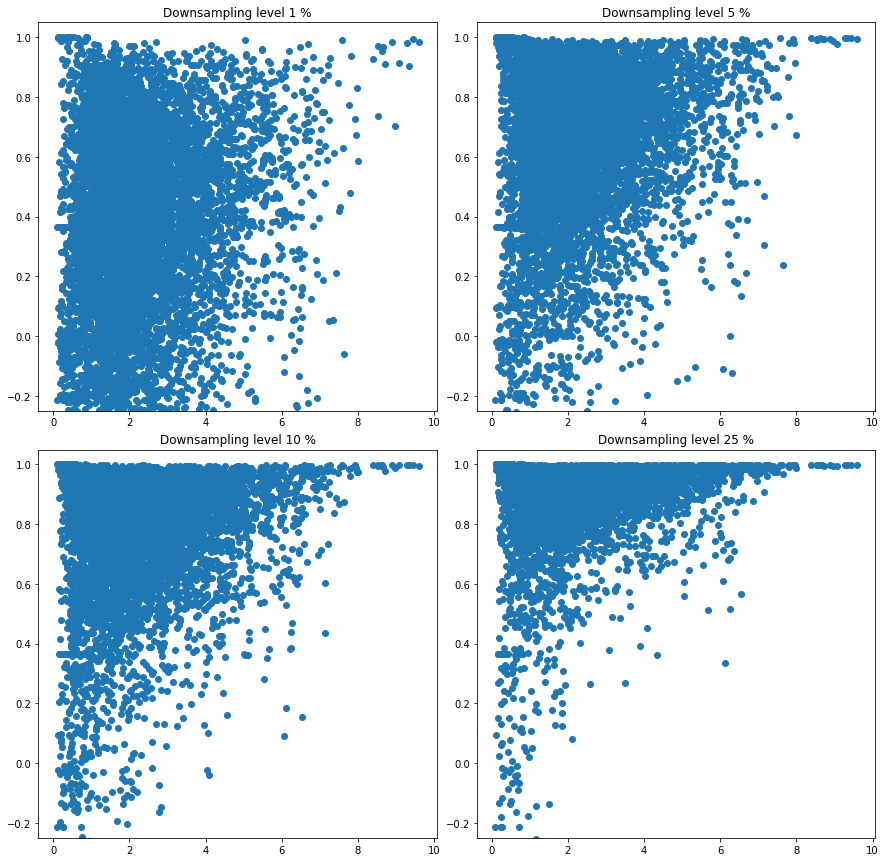

In [254]:
ct = 1
cellTypeSpecific2 = {}
for ds in downsamples:
    cellTypeSpecific2[ds] = []
    for gene in cellTypeAverages[ct][ds].index:
        cellTypeSpecific2[ds].append(pearsonr(cellTypeAverages[ct][ds].loc[gene], cellTypeAverages[ct]["full"].loc[gene])[0])
        
        
fig = plt.figure(figsize=(15, 15))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i in range(1, 5):
    ax = fig.add_subplot(2, 2, i)
    ax.set_title("Downsampling level %s %%" % downsamples[i - 1])
    cor_tpm = pandas.DataFrame({"tpm": avgTpm, "cor": cellTypeSpecific2[downsamples[i - 1]]})
    #cor_tpm = cor_tpm[(cor_tpm["tpm"] > 100) & (cor_tpm["tpm"] < 1000)]
    ax.scatter(cor_tpm["tpm"], cor_tpm["cor"])
    ax.set_ylim((-0.25, 1.05))


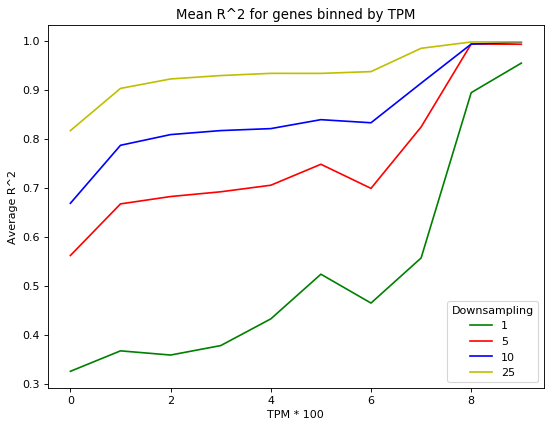

In [255]:

corr_dict = {}
for ds in downsamples:
    corr_dict[ds] = {}
        
for ds in downsamples:
    for x, y in zip(avgTpm, cellTypeSpecific2[ds]):
        bin_for_gene = int(x)
        if bin_for_gene not in corr_dict[ds]:
            corr_dict[ds][bin_for_gene] = []
        corr_dict[ds][bin_for_gene].append(y)
   

corr_dict_mean2 = {}
for ds in downsamples:
    corr_dict_mean2[ds] = []
corr_dict_number = {}
xs = sorted(corr_dict["1"].keys())

for ds in downsamples:
    corr_dict_mean[ds] = []
    corr_dict_number[ds] = []
    for i in range(max(corr_dict[ds].keys()) + 1):
        if i in corr_dict[ds]:
            corr_dict_mean2[ds].append(mean(corr_dict[ds][i]))
            corr_dict_number[ds].append(len(corr_dict[ds][i]))
            
figure = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
p1 = plt.plot(xs[:slicing], corr_dict_mean2["1"][:slicing], 'g', markersize=3)
p2 = plt.plot(xs[:slicing], corr_dict_mean2["5"][:slicing], 'r', markersize=3)
p3 = plt.plot(xs[:slicing], corr_dict_mean2["10"][:slicing], 'b', markersize=3)
p4 = plt.plot(xs[:slicing], corr_dict_mean2["25"][:slicing], 'y', markersize=3)
legend = plt.legend((p1[0], p2[0], p3[0], p4[0]), ("1", "5", "10", "25"), title="Downsampling")
title = plt.title("Mean R^2 for genes binned by TPM")
xlabel = plt.xlabel('TPM * 100')
ylabel = plt.ylabel('Average R^2')

# Cell type 2 (299 cells)

In [ ]:
ct = 2
cellTypeSpecific3 = {}
for ds in downsamples:
    cellTypeSpecific3[ds] = []
    for gene in cellTypeAverages[ct][ds].index:
        cellTypeSpecific3[ds].append(pearsonr(cellTypeAverages[ct][ds].loc[gene], cellTypeAverages[ct]["full"].loc[gene])[0])
        
        
fig = plt.figure(figsize=(15, 15))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i in range(1, 5):
    ax = fig.add_subplot(2, 2, i)
    ax.set_title("Downsampling level %s %%" % downsamples[i - 1])
    cor_tpm = pandas.DataFrame({"tpm": avgTpm, "cor": cellTypeSpecific3[downsamples[i - 1]]})
    #cor_tpm = cor_tpm[(cor_tpm["tpm"] > 100) & (cor_tpm["tpm"] < 1000)]
    ax.scatter(cor_tpm["tpm"], cor_tpm["cor"])
    ax.set_ylim((-0.25, 1.05))


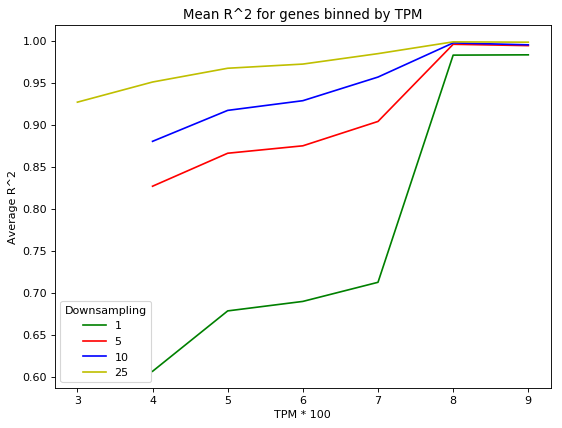

In [256]:

corr_dict = {}
for ds in downsamples:
    corr_dict[ds] = {}
        
for ds in downsamples:
    for x, y in zip(avgTpm, cellTypeSpecific3[ds]):
        bin_for_gene = int(x)
        if bin_for_gene not in corr_dict[ds]:
            corr_dict[ds][bin_for_gene] = []
        corr_dict[ds][bin_for_gene].append(y)
   

corr_dict_mean3 = {}
for ds in downsamples:
    corr_dict_mean3[ds] = []
corr_dict_number = {}
xs = sorted(corr_dict["1"].keys())

for ds in downsamples:
    corr_dict_mean[ds] = []
    corr_dict_number[ds] = []
    for i in range(max(corr_dict[ds].keys()) + 1):
        if i in corr_dict[ds]:
            corr_dict_mean3[ds].append(mean(corr_dict[ds][i]))
            corr_dict_number[ds].append(len(corr_dict[ds][i]))
            
figure = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
p1 = plt.plot(xs[:slicing], corr_dict_mean3["1"][:slicing], 'g', markersize=3)
p2 = plt.plot(xs[:slicing], corr_dict_mean3["5"][:slicing], 'r', markersize=3)
p3 = plt.plot(xs[:slicing], corr_dict_mean3["10"][:slicing], 'b', markersize=3)
p4 = plt.plot(xs[:slicing], corr_dict_mean3["25"][:slicing], 'y', markersize=3)
legend = plt.legend((p1[0], p2[0], p3[0], p4[0]), ("1", "5", "10", "25"), title="Downsampling")
title = plt.title("Mean R^2 for genes binned by TPM")
xlabel = plt.xlabel('TPM * 100')
ylabel = plt.ylabel('Average R^2')

# Cell type 3 (153 cells)

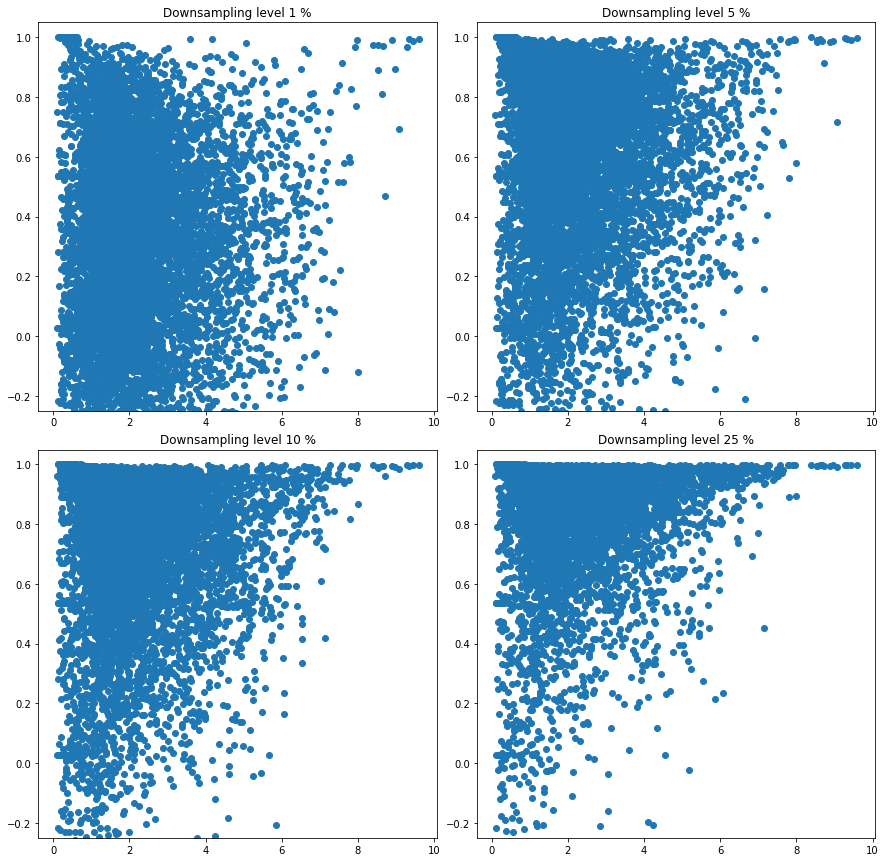

In [257]:
ct = 3
cellTypeSpecific4 = {}
for ds in downsamples:
    cellTypeSpecific4[ds] = []
    for gene in cellTypeAverages[ct][ds].index:
        cellTypeSpecific4[ds].append(pearsonr(cellTypeAverages[ct][ds].loc[gene], cellTypeAverages[ct]["full"].loc[gene])[0])
        
        
fig = plt.figure(figsize=(15, 15))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i in range(1, 5):
    ax = fig.add_subplot(2, 2, i)
    ax.set_title("Downsampling level %s %%" % downsamples[i - 1])
    cor_tpm = pandas.DataFrame({"tpm": avgTpm, "cor": cellTypeSpecific4[downsamples[i - 1]]})
    #cor_tpm = cor_tpm[(cor_tpm["tpm"] > 100) & (cor_tpm["tpm"] < 1000)]
    ax.scatter(cor_tpm["tpm"], cor_tpm["cor"])
    ax.set_ylim((-0.25, 1.05))


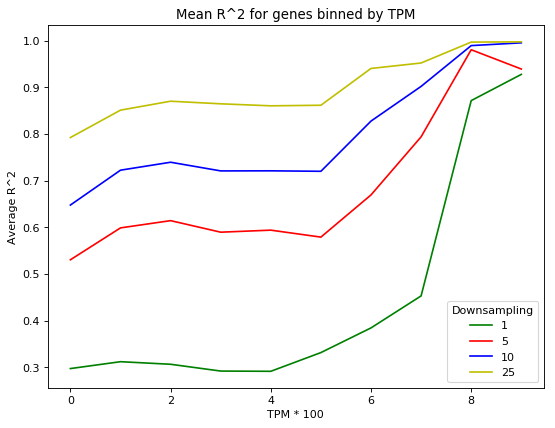

In [258]:

corr_dict = {}
for ds in downsamples:
    corr_dict[ds] = {}
        
for ds in downsamples:
    for x, y in zip(avgTpm, cellTypeSpecific4[ds]):
        bin_for_gene = int(x)
        if bin_for_gene not in corr_dict[ds]:
            corr_dict[ds][bin_for_gene] = []
        corr_dict[ds][bin_for_gene].append(y)
   

corr_dict_mean4 = {}
for ds in downsamples:
    corr_dict_mean4[ds] = []
corr_dict_number = {}
xs = sorted(corr_dict["1"].keys())

for ds in downsamples:
    corr_dict_mean[ds] = []
    corr_dict_number[ds] = []
    for i in range(max(corr_dict[ds].keys()) + 1):
        if i in corr_dict[ds]:
            corr_dict_mean4[ds].append(mean(corr_dict[ds][i]))
            corr_dict_number[ds].append(len(corr_dict[ds][i]))
            
figure = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
p1 = plt.plot(xs[:slicing], corr_dict_mean4["1"][:slicing], 'g', markersize=3)
p2 = plt.plot(xs[:slicing], corr_dict_mean4["5"][:slicing], 'r', markersize=3)
p3 = plt.plot(xs[:slicing], corr_dict_mean4["10"][:slicing], 'b', markersize=3)
p4 = plt.plot(xs[:slicing], corr_dict_mean4["25"][:slicing], 'y', markersize=3)
legend = plt.legend((p1[0], p2[0], p3[0], p4[0]), ("1", "5", "10", "25"), title="Downsampling")
title = plt.title("Mean R^2 for genes binned by TPM")
xlabel = plt.xlabel('TPM * 100')
ylabel = plt.ylabel('Average R^2')

# Cell type 4 (570 cells)

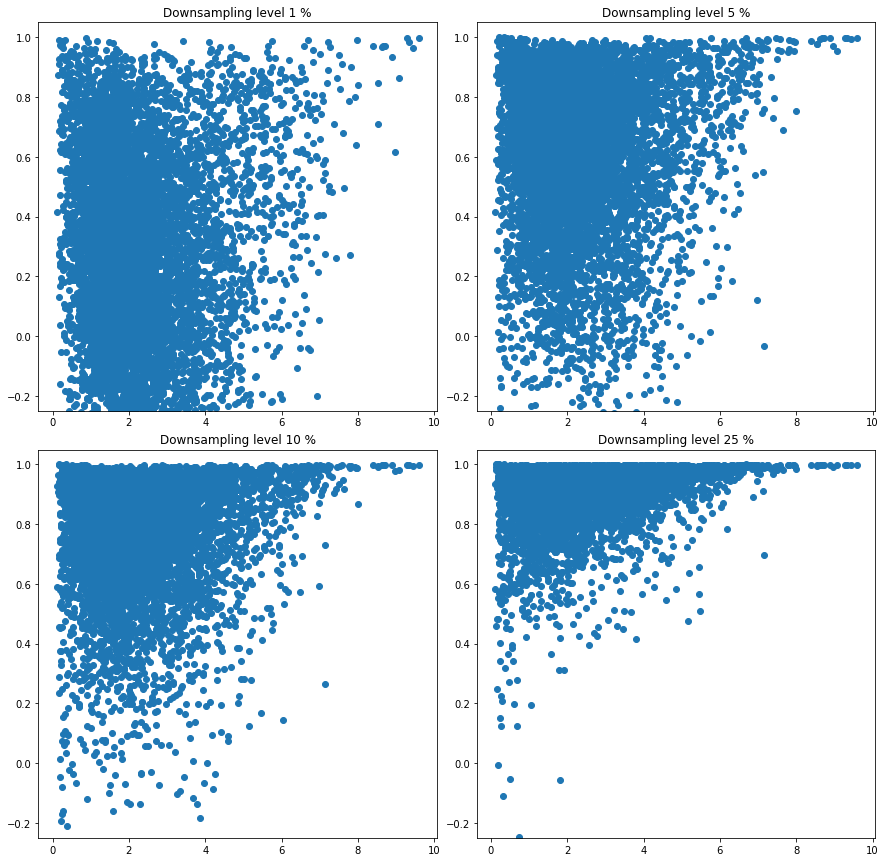

In [259]:
ct = 4
cellTypeSpecific5 = {}
for ds in downsamples:
    cellTypeSpecific5[ds] = []
    for gene in cellTypeAverages[ct][ds].index:
        cellTypeSpecific5[ds].append(pearsonr(cellTypeAverages[ct][ds].loc[gene], cellTypeAverages[ct]["full"].loc[gene])[0])
        
        
fig = plt.figure(figsize=(15, 15))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i in range(1, 5):
    ax = fig.add_subplot(2, 2, i)
    ax.set_title("Downsampling level %s %%" % downsamples[i - 1])
    cor_tpm = pandas.DataFrame({"tpm": avgTpm, "cor": cellTypeSpecific5[downsamples[i - 1]]})
    #cor_tpm = cor_tpm[(cor_tpm["tpm"] > 100) & (cor_tpm["tpm"] < 1000)]
    ax.scatter(cor_tpm["tpm"], cor_tpm["cor"])
    ax.set_ylim((-0.25, 1.05))


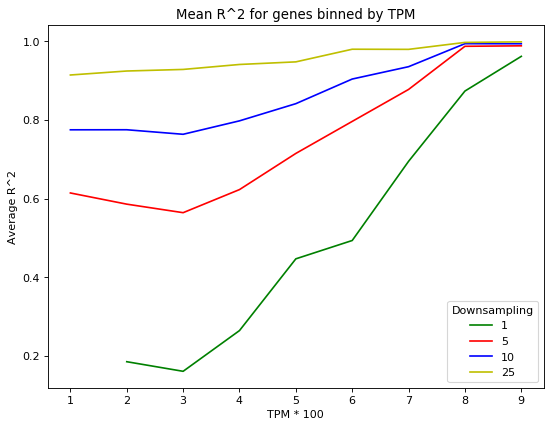

In [260]:

corr_dict = {}
for ds in downsamples:
    corr_dict[ds] = {}
        
for ds in downsamples:
    for x, y in zip(avgTpm, cellTypeSpecific5[ds]):
        bin_for_gene = int(x)
        if bin_for_gene not in corr_dict[ds]:
            corr_dict[ds][bin_for_gene] = []
        corr_dict[ds][bin_for_gene].append(y)
   

corr_dict_mean5 = {}
for ds in downsamples:
    corr_dict_mean5[ds] = []
corr_dict_number = {}
xs = sorted(corr_dict["1"].keys())

for ds in downsamples:
    corr_dict_mean[ds] = []
    corr_dict_number[ds] = []
    for i in range(max(corr_dict[ds].keys()) + 1):
        if i in corr_dict[ds]:
            corr_dict_mean5[ds].append(mean(corr_dict[ds][i]))
            corr_dict_number[ds].append(len(corr_dict[ds][i]))
            
figure = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
p1 = plt.plot(xs[:slicing], corr_dict_mean5["1"][:slicing], 'g', markersize=3)
p2 = plt.plot(xs[:slicing], corr_dict_mean5["5"][:slicing], 'r', markersize=3)
p3 = plt.plot(xs[:slicing], corr_dict_mean5["10"][:slicing], 'b', markersize=3)
p4 = plt.plot(xs[:slicing], corr_dict_mean5["25"][:slicing], 'y', markersize=3)
legend = plt.legend((p1[0], p2[0], p3[0], p4[0]), ("1", "5", "10", "25"), title="Downsampling")
title = plt.title("Mean R^2 for genes binned by TPM")
xlabel = plt.xlabel('TPM * 100')
ylabel = plt.ylabel('Average R^2')

# Cell type 5 (96 cells)

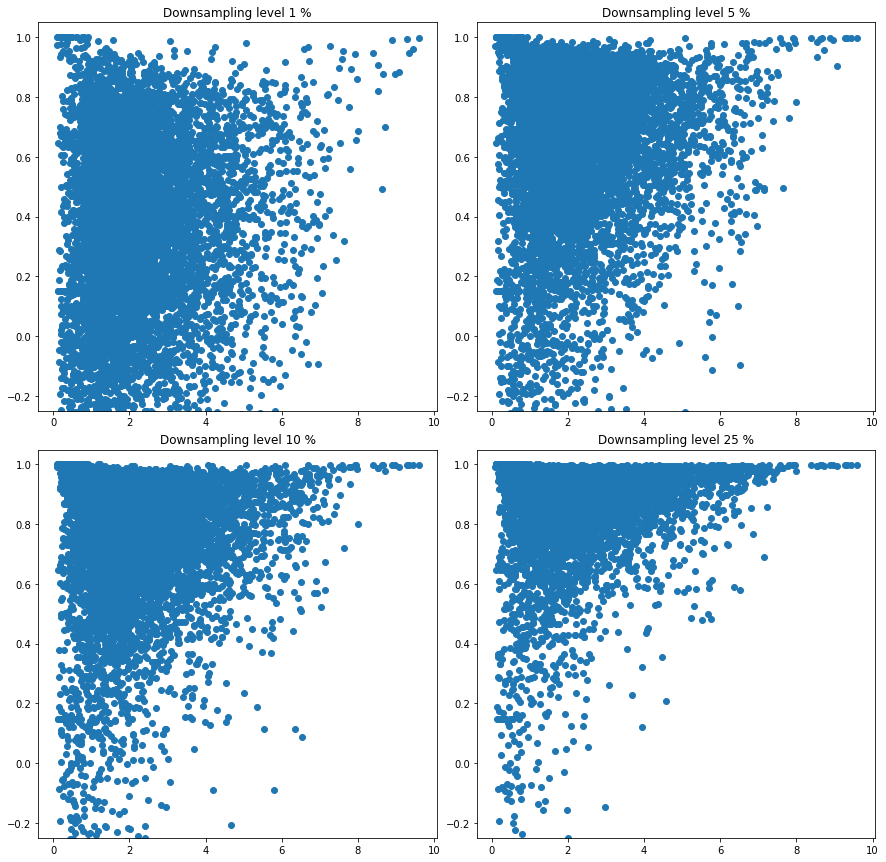

In [261]:
ct = 5
cellTypeSpecific6 = {}
for ds in downsamples:
    cellTypeSpecific6[ds] = []
    for gene in cellTypeAverages[ct][ds].index:
        cellTypeSpecific6[ds].append(pearsonr(cellTypeAverages[ct][ds].loc[gene], cellTypeAverages[ct]["full"].loc[gene])[0])
        
        
fig = plt.figure(figsize=(15, 15))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i in range(1, 5):
    ax = fig.add_subplot(2, 2, i)
    ax.set_title("Downsampling level %s %%" % downsamples[i - 1])
    cor_tpm = pandas.DataFrame({"tpm": avgTpm, "cor": cellTypeSpecific6[downsamples[i - 1]]})
    #cor_tpm = cor_tpm[(cor_tpm["tpm"] > 100) & (cor_tpm["tpm"] < 1000)]
    ax.scatter(cor_tpm["tpm"], cor_tpm["cor"])
    ax.set_ylim((-0.25, 1.05))


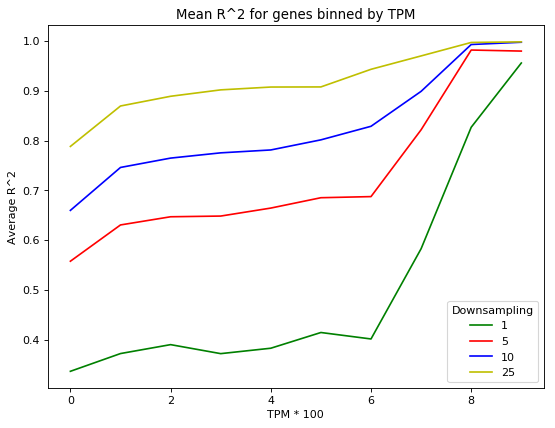

In [262]:

corr_dict = {}
for ds in downsamples:
    corr_dict[ds] = {}
        
for ds in downsamples:
    for x, y in zip(avgTpm, cellTypeSpecific6[ds]):
        bin_for_gene = int(x)
        if bin_for_gene not in corr_dict[ds]:
            corr_dict[ds][bin_for_gene] = []
        corr_dict[ds][bin_for_gene].append(y)
   

corr_dict_mean6 = {}
for ds in downsamples:
    corr_dict_mean6[ds] = []
corr_dict_number = {}
xs = sorted(corr_dict["1"].keys())

for ds in downsamples:
    corr_dict_mean[ds] = []
    corr_dict_number[ds] = []
    for i in range(max(corr_dict[ds].keys()) + 1):
        if i in corr_dict[ds]:
            corr_dict_mean6[ds].append(mean(corr_dict[ds][i]))
            corr_dict_number[ds].append(len(corr_dict[ds][i]))
            
figure = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
p1 = plt.plot(xs[:slicing], corr_dict_mean6["1"][:slicing], 'g', markersize=3)
p2 = plt.plot(xs[:slicing], corr_dict_mean6["5"][:slicing], 'r', markersize=3)
p3 = plt.plot(xs[:slicing], corr_dict_mean6["10"][:slicing], 'b', markersize=3)
p4 = plt.plot(xs[:slicing], corr_dict_mean6["25"][:slicing], 'y', markersize=3)
legend = plt.legend((p1[0], p2[0], p3[0], p4[0]), ("1", "5", "10", "25"), title="Downsampling")
title = plt.title("Mean R^2 for genes binned by TPM")
xlabel = plt.xlabel('TPM * 100')
ylabel = plt.ylabel('Average R^2')

In [411]:
ct1means = [nanmean(cellTypeSpecific1["1"]), 
            nanmean(cellTypeSpecific1["5"]), 
            nanmean(cellTypeSpecific1["10"]), 
            nanmean(cellTypeSpecific1["25"]), 
            nanmean(cellTypeSpecific1["full"])]

ct2means = [nanmean(cellTypeSpecific2["1"]), 
            nanmean(cellTypeSpecific2["5"]), 
            nanmean(cellTypeSpecific2["10"]), 
            nanmean(cellTypeSpecific2["25"]), 
            nanmean(cellTypeSpecific2["full"])]

ct3means = [nanmean(cellTypeSpecific3["1"]), 
            nanmean(cellTypeSpecific3["5"]), 
            nanmean(cellTypeSpecific3["10"]), 
            nanmean(cellTypeSpecific3["25"]), 
            nanmean(cellTypeSpecific3["full"])]

ct4means = [nanmean(cellTypeSpecific4["1"]), 
            nanmean(cellTypeSpecific4["5"]), 
            nanmean(cellTypeSpecific4["10"]), 
            nanmean(cellTypeSpecific4["25"]), 
            nanmean(cellTypeSpecific4["full"])]

ct5means = [nanmean(cellTypeSpecific5["1"]), 
            nanmean(cellTypeSpecific5["5"]), 
            nanmean(cellTypeSpecific5["10"]), 
            nanmean(cellTypeSpecific5["25"]), 
            nanmean(cellTypeSpecific5["full"])]

ct6means = [nanmean(cellTypeSpecific6["1"]), 
            nanmean(cellTypeSpecific6["5"]), 
            nanmean(cellTypeSpecific6["10"]), 
            nanmean(cellTypeSpecific6["25"]), 
            nanmean(cellTypeSpecific6["full"])]

ctmeans = ct1means + ct2means + ct3means + ct4means + ct5means + ct6means
cttypes = 5 * ["0 - 870 cells"] + 5 * [1] + 5 * [2] + 5 * [3] + 5 * [4] + 5 * [5]
ctdowns = 6 * ["1", "5", "10", "25", "full"]
ctbars = pandas.DataFrame({"cor_means": ctmeans, "cell_types": cttypes, "downsampling": ctdowns})

# Mean pearson correlation for each cell type across different subsampling levels

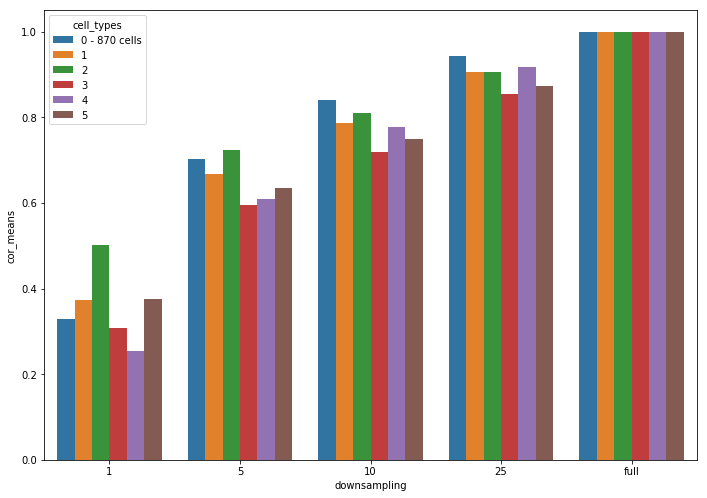

In [416]:
a4_dims = (11.7, 8.27)

fig, ax = plt.subplots(figsize=a4_dims)

sns.barplot(x="downsampling", y="cor_means", hue="cell_types", data=ctbars)

# Why log transofrmation is better than raw data? Gene expression seems to be distributed as normal with an inflated 0 component

/home/igorm/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


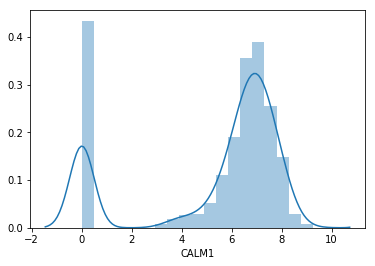

In [302]:
sns.distplot(kallisto["1"].iloc[49][cell_type_dict[0]])

/home/igorm/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


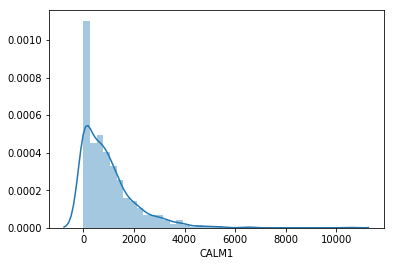

In [418]:
sns.distplot(kallisto["1"].iloc[49][cell_type_dict[0]].apply(lambda x: exp(x)))